In [ ]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 7.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

## **Prepare processor, model and image input**

In [ ]:
from PIL import Image, ImageFilter
import requests
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

device = torch.device("cpu")
print("You are currently using: ", device)

model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf").to(device)
processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", use_fast=False)

You are currently using:  cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/llava/configuration_llava.py:100: FutureWarning: The `vocab_size` argument is deprecated and will be removed in v4.42, since it can be inferred from the `text_config`. Passing this argument has no effect
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load and Preprocess Images**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re
from collections import Counter
from google.colab import drive

# Define paths
# data_path = 'drive/MyDrive/batch_1'
data_path = 'drive/MyDrive/batch_1'
images_path = os.path.join(data_path, 'background_images')
labels_path = os.path.join(data_path, 'JSON/kaggle_data_1.json')

# Load JSON file
with open(labels_path, 'r') as f:
    labels_data = json.load(f)

# Preprocess images
def preprocess_image(image_path, target_size=(256, 256)):
    image = Image.open(image_path).convert("RGB")  # Convert to RGB
    image = image.resize(target_size)  # Resize to a fixed dimension to ensure uniform size
    image = image.filter(ImageFilter.MedianFilter())  # Apply median filter for noise reduction
    image = Image.fromarray(np.uint8((np.array(image) > 128) * 255))  # Apply thresholding
    return image

images = []
labels = []

for idx, item in enumerate(labels_data):
    if idx >= 100:     # limit to processing 100 images for sake of speed
        break

    img_path = os.path.join(images_path, item['filename'])
    label = item['latex']
    image = preprocess_image(img_path)
    images.append(image)
    labels.append(label)

label_to_index = {label: idx for idx, label in enumerate(set(labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
labels_indices = [label_to_index[label] for label in labels]

## **Generate Latex Predictions**


In [ ]:
def generate_latex_prediction(image, prompt, processor, model, device):
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generate_ids = model.generate(**inputs, max_new_tokens=300)
    processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    response_tokens = generate_ids[0]
    response_text = processor.decode(response_tokens, skip_special_tokens=True)
    response_text = response_text.replace("\\\\", "\\")
    return response_text

def clean_latex(predicted_latex):
    cleaned_latex = predicted_latex
    replacements = [
        "USER:  <image> ",
        "Please convert the content of this image to LaTeX math format. Include all mathematical expressions accurately, such as limits (\\lim), integrals (\\int), derivatives (\\frac{{d}}{{dx}}), variables (like a, b, c), constants (\\pi), functions (\\sin, \\cos, \\tan, \\sec), and any other symbols. Ensure all elements are represented in LaTeX format without using the 'align' environment. Provide only the LaTeX math code, without any additional explanation or formatting. ASSISTANT: ",
        "\\begin{aligned}",
        "\\end{aligned}"
    ]

    for r in replacements:
        cleaned_latex = cleaned_latex.replace(r, "")

    cleaned_latex = cleaned_latex.strip()
    return cleaned_latex

prompt = ("USER: <image>\n"
    "Please convert the content of this image to LaTeX math format. Include all mathematical expressions accurately, "
    "such as limits (\\lim), integrals (\\int), derivatives (\\frac{{d}}{{dx}}), variables (like a, b, c), "
    "constants (\\pi), functions (\\sin, \\cos, \\tan, \\sec), and any other symbols. Ensure all elements are represented in LaTeX format without using the 'align' environment. "
    "Provide only the LaTeX math code, without any additional explanation or formatting. ASSISTANT:"
)

## **Create Datasets**

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

train_images, test_images, train_labels, test_labels = train_test_split(images, labels_indices, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)

# Convert images to tensors and create DataLoader
def images_to_tensor(images):
    return torch.stack([torch.tensor(np.array(image)) for image in images])

train_tensors = images_to_tensor(train_images).unsqueeze(1)
val_tensors = images_to_tensor(val_images).unsqueeze(1)
test_tensors = images_to_tensor(test_images).unsqueeze(1)

train_dataset = TensorDataset(train_tensors, torch.tensor(train_labels))
val_dataset = TensorDataset(val_tensors, torch.tensor(val_labels))
test_dataset = TensorDataset(test_tensors, torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


## **Evaluate Accuracy/Results**

In [ ]:
def split_latex_string(latex):
    tokens = re.findall(r'\\[a-zA-Z]+|[{}^_]|[0-9]+|\s+|.', latex)
    return [token for token in tokens if token.strip()]

def calculate_matching_metrics(predicted, ground_truth):
    predicted_tokens = split_latex_string(predicted)
    ground_truth_tokens = split_latex_string(ground_truth)

    predicted_counter = Counter(predicted_tokens)
    ground_truth_counter = Counter(ground_truth_tokens)

    # Calculate the number of matching tokens
    matches = sum((predicted_counter & ground_truth_counter).values())

    # Calculate the total number of tokens in the ground truth and predicted
    total_ground_truth_tokens = sum(ground_truth_counter.values())
    total_predicted_tokens = sum(predicted_counter.values())

    # Calculate mismatches
    mismatches = abs(total_ground_truth_tokens - matches) + abs(total_predicted_tokens - matches)

    # Calculate precision and recall
    precision = matches / total_predicted_tokens if total_predicted_tokens > 0 else 0
    recall = matches / total_ground_truth_tokens if total_ground_truth_tokens > 0 else 0

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Calculate matching percentage
    total_tokens = total_ground_truth_tokens + total_predicted_tokens
    matching_percentage = (matches / total_tokens) * 100 if total_tokens > 0 else 0

    return matching_percentage, precision, recall, f1_score, matches, total_ground_truth_tokens

predicted_latex = ""
predicted_latex_list = []

ground_truth_latex = ""
ground_truth_latex_list = []

matching_percentages = []
avg_percent = 0

f1_scores = []
avg_f1 = 0

recall = 0
avg_recall = 0

precision = 0
avg_precision = 0

processing = 0

for images, labels in train_loader:
    images = images.to(device)
    for i in range(len(images)):
        processing += 1
        predicted_latex = generate_latex_prediction(images[i], prompt, processor, model, device)
        predicted_latex = clean_latex(predicted_latex)
        ground_truth_latex = index_to_label[labels[i].item()]
        matching_percentage, precision, recall, f1_score, matches, total_tokens = calculate_matching_metrics(predicted_latex, ground_truth_latex)

        print(f"Matching Percentage: {matching_percentage:.2f}%")
        print(f"F1-Score: {f1_score:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print()

        ground_truth_latex_list.append(ground_truth_latex)
        predicted_latex_list.append(predicted_latex)
        matching_percentages.append(matching_percentage)
        f1_scores.append(f1_score)

        avg_percent += matching_percentage
        avg_f1 += f1_score
        avg_recall += recall
        avg_precision += precision


print("Processed " + str(processing) + " images")
avg_percent = avg_percent / processing
avg_f1 = avg_f1 / processing
avg_recall = avg_recall / processing
avg_recall *= 100
avg_precision = avg_precision / processing
avg_precision *= 100

print(f"Average Matching Percentage: {avg_percent:.2f}%")
print(f"Average F1 Score: {avg_f1:.2f}")
print(f"Average Precision: {avg_precision:.2f}%")
print(f"Average Recall: {avg_recall:.2f}%")




Matching Percentage: 20.65%
F1-Score: 0.41
Precision: 0.73
Recall: 0.29

Matching Percentage: 11.41%
F1-Score: 0.23
Precision: 0.14
Recall: 0.59

Matching Percentage: 10.70%
F1-Score: 0.21
Precision: 0.13
Recall: 0.62

Matching Percentage: 5.35%
F1-Score: 0.11
Precision: 0.06
Recall: 0.71

Matching Percentage: 11.36%
F1-Score: 0.23
Precision: 0.71
Recall: 0.14

Matching Percentage: 6.17%
F1-Score: 0.12
Precision: 0.07
Recall: 0.50

Matching Percentage: 24.64%
F1-Score: 0.49
Precision: 0.65
Recall: 0.40

Matching Percentage: 25.00%
F1-Score: 0.50
Precision: 0.79
Recall: 0.37

Matching Percentage: 21.21%
F1-Score: 0.42
Precision: 0.32
Recall: 0.61

Matching Percentage: 16.30%
F1-Score: 0.33
Precision: 0.21
Recall: 0.71

Matching Percentage: 20.61%
F1-Score: 0.41
Precision: 0.29
Recall: 0.73

Matching Percentage: 24.59%
F1-Score: 0.49
Precision: 0.48
Recall: 0.51

Matching Percentage: 21.98%
F1-Score: 0.44
Precision: 0.35
Recall: 0.59

Matching Percentage: 25.58%
F1-Score: 0.51
Precision:

## **Plotting our Results**

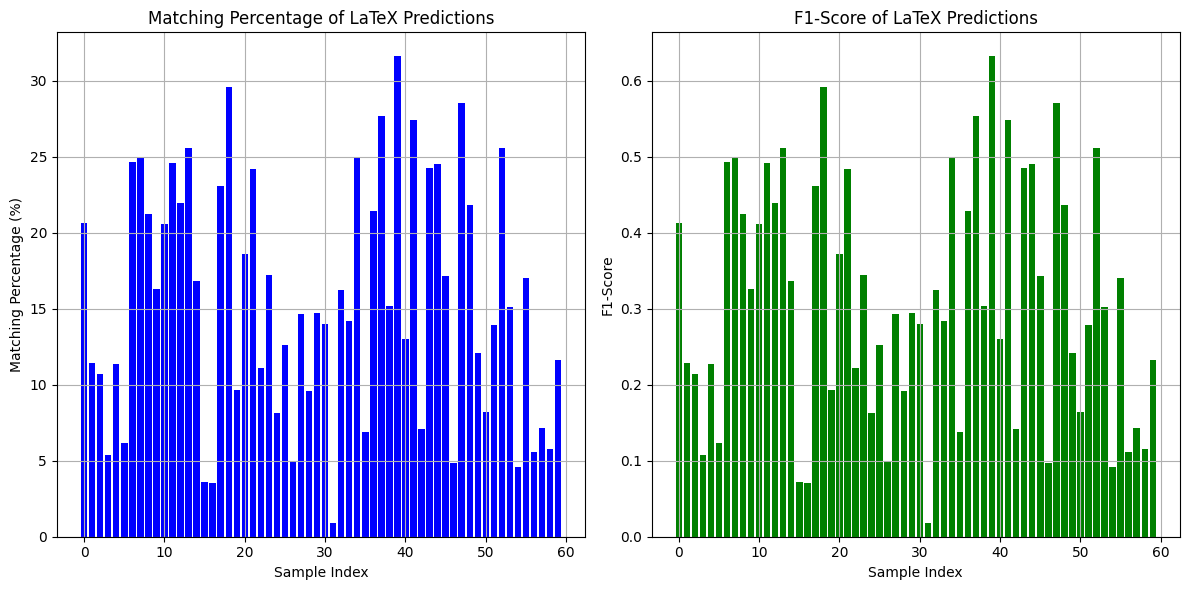

In [ ]:
import matplotlib.pyplot as plt

indices = np.arange(len(matching_percentages))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(indices, matching_percentages, color='b')
plt.title('Matching Percentage of LaTeX Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Matching Percentage (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(indices, f1_scores, color='g')
plt.title('F1-Score of LaTeX Predictions')
plt.xlabel('Sample Index')
plt.ylabel('F1-Score')
plt.grid(True)

# plt.plot(range(len(matching_percentages)), matching_percentages, marker='o', linestyle='-', color='b')
# plt.title('Accuracy Curve - Matching Percentage Over Images')
# plt.xlabel('Image Index')
# plt.ylabel('Matching Percentage')
# plt.grid(True)

plt.tight_layout()
plt.show()